# Идея

todo

In [2]:
import os

os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [3]:
%matplotlib inline
import numpy as np, matplotlib.pyplot as plt, glob, os
import random
import torch
from collections import deque

import gym
from gym import error, spaces, utils
from gym.utils import seeding

In [4]:
from ddpg_agent import Agent

### Env

In [5]:
# true system params
big_b=1
big_omega=1
theta=0
m=1
k=0.1
beta=0.02
big_f_0=1
t_min=0
t_max=10

t0 = 0
t_step = 1
n_steps = 20
n_prev = 3

delta = beta / (2 * m)
omega_0 = k / m

impact_amplitude = 1
damping_ratio = 0.05

In [6]:
def x_impact(t, a=impact_amplitude, b=damping_ratio):
#     if t < 0:
#         return 1
    return a * np.exp(-t * b)

def x_pendulum(t, big_b, big_omega, theta):
    return big_b * np.cos(big_omega * t - theta)

def generate_history(t0, step, n_steps, big_b=big_b, big_omega=big_omega, theta=theta,
                     impact=x_impact, x_pendulum=x_pendulum):
    res = []
    for _ in range(n_steps):
        res.append(
            x_pendulum(t0, big_b, big_omega, theta) * impact(t0)
        )
        t0 += step
    return res

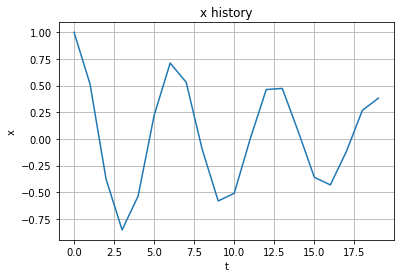

In [7]:

history = generate_history(t0, t_step, n_steps)

plt.title("x history")
plt.xlabel("t")
plt.ylabel("x")
plt.grid(True)
plt.plot(history)
plt.show()

In [8]:
class SimpleModel(gym.Env):
    
    def __init__(self, history, t0=t0, t_step=t_step, n_steps=n_steps, big_f_0=big_f_0, k=k,
                 n_prev=n_prev):
        self._history = history
        self._big_f_0 = big_f_0
        self._k = k

        self._last_x = self._history[:n_prev]
        self._t0 = t0
        self.t = t0
        self._t_step = t_step
        self._n_steps = n_steps
        self._n_prev = n_prev
        self._i = self._n_prev - 1
        self.t = self._t0 + self._t_step * self._i
        
        self.observation_space = spaces.Box(low=-100, high=100, shape=(self._n_prev,), dtype=np.float32)
        self.action_space = spaces.Box(np.array([0,-2,-.1]), np.array([+10,+2,+.1]), dtype=np.float32)
#         self.action_space = spaces.Box(low=-100, high=100, shape=(3,), dtype=np.float32)
 
        
    def _x_model(self, m, delta, big_omega, t=None):
        """Returns the model position."""
        big_b = self._big_b_model(m, delta, big_omega)
        theta = self._theta_model(m, delta, big_omega)
        if t is None:
            t = self.t
        return big_b * np.cos(big_omega * t - theta)
    
    def _big_b_model(self, m, delta, big_omega):
        omega_0_sqr = self._k / m
        f_0 = self._big_f_0 / m
        
        res = (omega_0_sqr**2 - big_omega**2)**2
        res += 4 * delta**2 * big_omega**2
        res = f_0 / res**0.5
        return res
    
    def _theta_model(self, m, delta, big_omega):
        omega_0_sqr = self._k / m
        
        res = 2 * delta * big_omega
        res /= omega_0_sqr - big_omega**2
        return res
    
    def step(self, action):

        # step
        self._i += 1
        self.t += self._t_step

        # reward
        m_, delta_, big_omega_ = action[0], action[1], action[2]
        big_b_ = self._big_b_model(m_, delta_, big_omega_)
        theta_ = self._theta_model(m_, delta_, big_omega_)
        x_ = self._x_model(m_, delta_, big_omega_)
#         reward = - (x_ - self._history[self._i]) ** 2
        reward = - (x_ - self._history[self._i]) ** 2 # TODO!!!!!-------------

        # done
        done = self._i >= self._n_steps - 1
        
        # info
        info = {}
        
        # obs
        if self._n_prev > 1:
            self._last_x = self._last_x[1:] + [x_]
        else:
            self._last_x = x_
        obs = np.array(self._last_x).reshape((-1,1))
        
        return obs, reward, done, info
    
    def reset(self):
        self._i = self._n_prev - 1
        self.t = self._t0 + self._t_step * self._i
        self._last_x = self._history[:self._n_prev]
        return np.array(self._last_x).reshape((-1,1))
    
    def render(self):
        pass

    

In [9]:
class ImpactWrapper(gym.ObservationWrapper):
    
    def __init__(self, env, impact_func, param1, param2):
        super().__init__(env)
        self.impact_func = impact_func
        self.param1 = param1
        self.param2 = param2
        self.observation_space = spaces.Box(low=-100, high=100, shape=(2 * self.env._n_prev + 2,), dtype=np.float32)
        
    def _get_impact(self, obs):
        o = list(obs.reshape((-1,)))
        impact = [self.impact_func(self.t - t_step * i) for i in range(n_prev)]
        o = np.array([self.param1, self.param2] + impact + o)
        return o
    
    def step(self, action):
        o, r, d, info =  self.env.step(action)
        return self._get_impact(o), r, d, info
        
    def reset(self):
        o = self.env.reset()
        return self._get_impact(o)

In [10]:
class NormActionWrapper(gym.ActionWrapper):
    def __init__(self, env):
        super().__init__(env)
        self._low = self.env.action_space.low
        self._high = self.env.action_space.high
        
    def step(self, action):
        action = (action * (self._high - self._low) + self._high + self._low) / 2
        o, r, d, info =  self.env.step(action)
        return o, r, d, info

# Some tests

In [11]:
history = generate_history(t0, t_step, n_steps, impact=lambda t: 1)
env = SimpleModel(history, t0, t_step, n_steps)

In [12]:
for i in range(20):
    env.reset()
    o, r, d, _ = env.step([m, delta, big_omega])
    assert np.isclose(r, 0, atol=1e-3)
o, r, d, _ = env.step([m, delta, big_omega + 1])
assert not np.isclose(r, 0, atol=1e-3)

reset_1 = env.reset()
for i in range(n_steps-n_prev):
    o, r, d, _ = env.step([0.1, 0.1, 0.1])
reset_2 = env.reset()
assert np.all(reset_1 == reset_2)

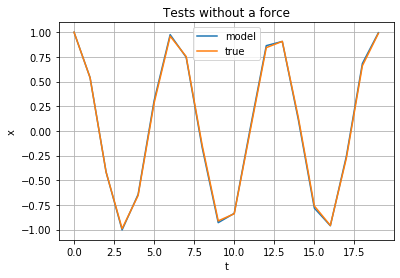

In [13]:
points = list(env.reset().reshape((-1,)))
points += [env.step([m, delta, big_omega])[0][-1][0] for _ in range(len(history) - n_prev)]
points = np.array(points).reshape((-1,))

# assert len(points) == len(history)
# for p, h in zip(*(points, history)):
#     assert np.isclose(p, h, atol=1e-1)
plt.plot(np.array(points).reshape((-1,1)), label="model")
plt.plot(history, label="true")
plt.grid(True)
plt.legend()
plt.title("Tests without a force")
plt.xlabel("t")
plt.ylabel("x")
plt.show()

In [14]:
history = generate_history(t0, t_step, n_steps, impact=x_impact)
env = SimpleModel(history, t0, t_step, n_steps)
env = ImpactWrapper(env, x_impact, param1=impact_amplitude, param2=damping_ratio)

In [15]:
# points = [env.reset()]
# points += [env.step([m, delta, big_omega])[0] for _ in range(len(history) - 1)]
# points = np.array(points).T

# assert points[0].shape == points[1].shape
# plt.plot(points[0]*points[1] + 0.01, label="model with force")
# plt.plot(points[0], label="model")
# plt.plot(points[1], label="force")
# plt.plot(history, label="true")
# plt.grid(True)
# plt.legend()
# plt.title("Tests with a force")
# plt.xlabel("t")
# plt.ylabel("x")
# plt.show()

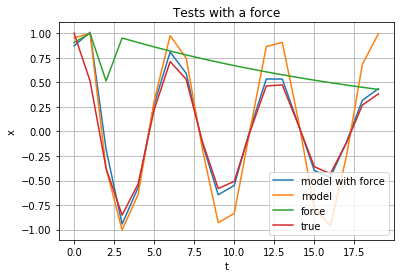

In [16]:
points = list(env.reset().reshape((-1,))[2:].reshape((-1,2)))
points += [env.step([m, delta, big_omega])[0][n_prev+1::n_prev] for _ in range(len(history) - n_prev)]
points = np.array(points).T

assert points[0].shape == points[1].shape
plt.plot(points[0]*points[1] + 0.01, label="model with force")
plt.plot(points[1], label="model")
plt.plot(points[0], label="force")
plt.plot(history, label="true")
plt.grid(True)
plt.legend()
plt.title("Tests with a force")
plt.xlabel("t")
plt.ylabel("x")
plt.show()

# CE

from https://github.com/udacity/deep-reinforcement-learning/blob/master/cross-entropy/CEM.ipynb

In [17]:
test_history = generate_history(t0, t_step, n_steps)
test_env = SimpleModel(test_history, t0, t_step, n_steps)
test_env = ImpactWrapper(test_env, x_impact, impact_amplitude, damping_ratio)
# test_env = NormActionWrapper(test_env)

In [18]:
import gym
import math
import numpy as np
from collections import deque
import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

In [19]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

env.seed(101)
np.random.seed(101)

print('observation space:', env.observation_space)
print('action space:', env.action_space)
print('  - low:', env.action_space.low)
print('  - high:', env.action_space.high)

class Agent(nn.Module):
    def __init__(self, base_env, h_size=16):
        super(Agent, self).__init__()
        # state, hidden layer, action sizes
        self.s_size = base_env.observation_space.shape[0]
        self.h_size = h_size
        self.a_size = base_env.action_space.shape[0]
        # define layers
        self.fc1 = nn.Linear(self.s_size, self.h_size)
        self.fc2 = nn.Linear(self.h_size, self.a_size)
        
    def set_weights(self, weights):
        s_size = self.s_size
        h_size = self.h_size
        a_size = self.a_size
        # separate the weights for each layer
        fc1_end = (s_size*h_size)+h_size
        fc1_W = torch.from_numpy(weights[:s_size*h_size].reshape(s_size, h_size))
        fc1_b = torch.from_numpy(weights[s_size*h_size:fc1_end])
        fc2_W = torch.from_numpy(weights[fc1_end:fc1_end+(h_size*a_size)].reshape(h_size, a_size))
        fc2_b = torch.from_numpy(weights[fc1_end+(h_size*a_size):])
        # set the weights for each layer
        self.fc1.weight.data.copy_(fc1_W.view_as(self.fc1.weight.data))
        self.fc1.bias.data.copy_(fc1_b.view_as(self.fc1.bias.data))
        self.fc2.weight.data.copy_(fc2_W.view_as(self.fc2.weight.data))
        self.fc2.bias.data.copy_(fc2_b.view_as(self.fc2.bias.data))
    
    def get_weights_dim(self):
        return (self.s_size+1)*self.h_size + (self.h_size+1)*self.a_size
        
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = torch.tanh(self.fc2(x) / 1000) #TODO: batchnorm
#         x = self.fc2(x)
        return x.cpu().data
        
    def evaluate(self, env, weights, gamma=1.0, max_t=5000):
        self.set_weights(weights)
        episode_return = 0.0
        state = env.reset()
        for t in range(max_t):
            state = torch.from_numpy(state).float().to(device)
            action = self.forward(state)
            state, reward, done, _ = env.step(action.numpy())
            episode_return += reward * math.pow(gamma, t)
            if done:
                break
        return episode_return
    
agent = Agent(test_env, h_size=32).to(device)

observation space: Box(8,)
action space: Box(3,)
  - low: [ 0.  -2.  -0.1]
  - high: [10.   2.   0.1]


In [20]:
# def plot_result(env, agent, title_info=""):
#     s = env.reset()
#     d = False
#     points = [s[0]]
#     while not d:
#         state = torch.from_numpy(s).float().to(device)
#         a = list(agent(state).numpy())
#         print(a)
#         s, r, d, _ = env.step(a)
#         points.append(s[0])

#     plt.plot(points, label="model")
#     plt.plot(history, label="true")
#     plt.title("CE training" + title_info)
#     plt.xlabel("t")
#     plt.ylabel("x")
#     plt.grid(True)
#     plt.legend()
#     plt.show()

In [21]:
def plot_result(env, model, title_info=""):
    s = env.reset()
    d = False
    points = list(s)[-n_prev:]
    while not d:
        state = torch.from_numpy(s).float().to(device)
        a = list(model(state).numpy())
        s, r, d, _ = env.step(a)
        points.append(s[-1])

    plt.plot(points, label="model")
    plt.plot(history, label="true")
    plt.title("CE training" + title_info)
    plt.xlabel("t")
    plt.ylabel("x")
    plt.grid(True)
    plt.legend()
    plt.show()

Episode 0


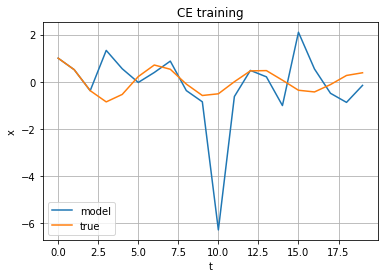

Episode 200	Average Score: -4.34
55.25716491770608 9.04814789840327 71.41402239257522


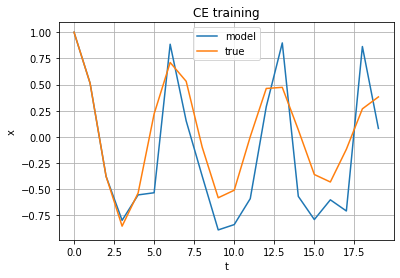

Episode 400	Average Score: -3.76
61.067085494851305 8.186898039137935 72.85660848981772


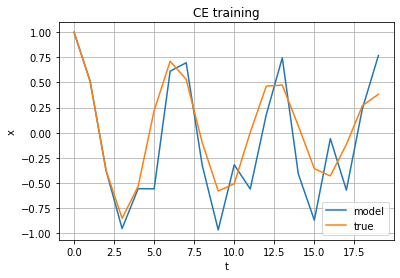

Episode 600	Average Score: -2.85
67.48788028465309 7.407626428726764 74.32833528769902


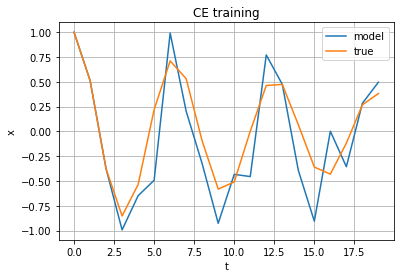

Episode 800	Average Score: -2.43
74.58377861670964 6.702529950324054 75.82979143769391


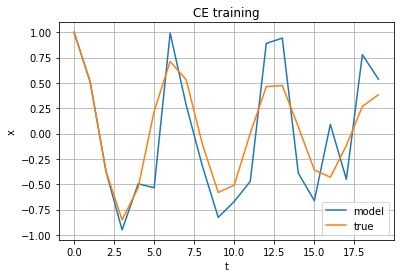

Episode 1000	Average Score: -2.09
82.42576310418404 6.064548228400948 77.3615774822255


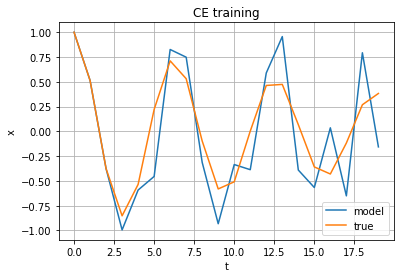

Episode 1200	Average Score: -2.15
91.09227970631348 5.487292930757126 78.92430609486564


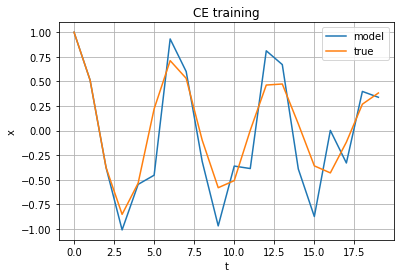

Episode 1400	Average Score: -2.19
100.67002244923151 4.964983799935317 80.51860232538854


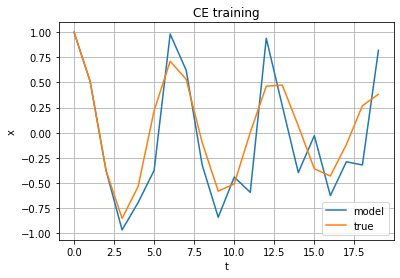

Episode 1600	Average Score: -1.53
111.25480065492714 4.492390773499101 82.14510384977368


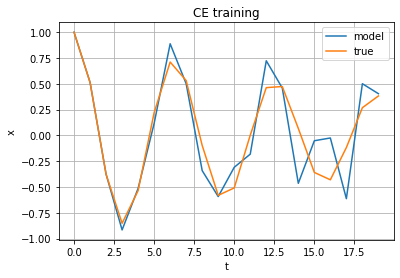

Episode 1800	Average Score: -1.23
122.95249735351658 4.064781613604211 83.80446122525935


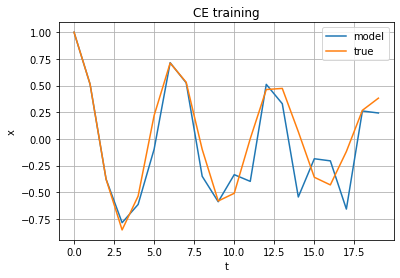

Episode 2000	Average Score: -1.08
135.88012846614183 3.677874521460117 85.49733815054817


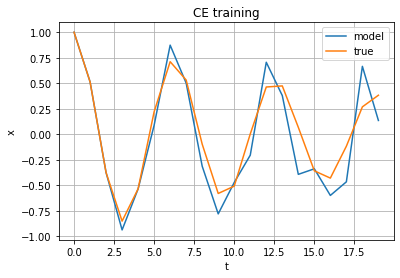

Episode 2200	Average Score: -1.11
150.16701335385392 3.3277952621940243 87.22441173126889


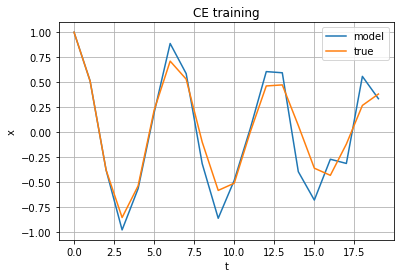

Episode 2400	Average Score: -0.87
165.95606844186554 3.0110383707937194 88.9863727508005


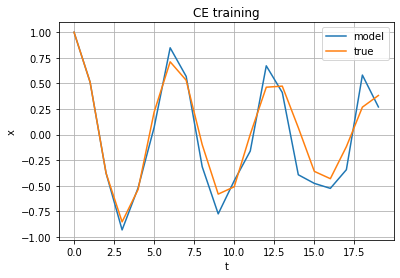

Episode 2600	Average Score: -0.80
183.40523685972585 2.724432050670879 90.78392594656738


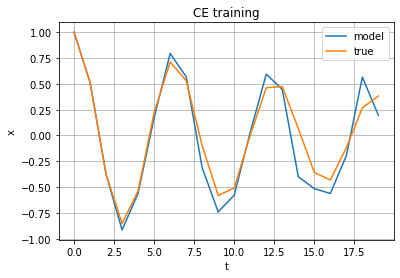

Episode 2800	Average Score: -0.89
202.68906839857615 2.465106413362019 92.61779029191507


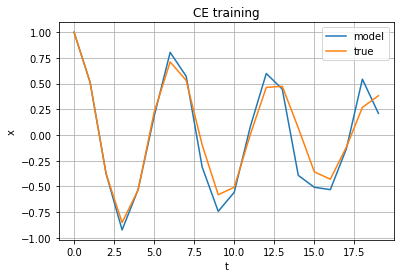

Episode 3000	Average Score: -0.68
224.0004655903266 2.230464741340194 94.48869928368086


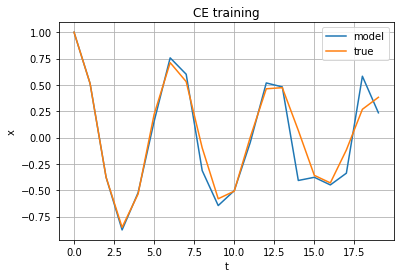

Episode 3200	Average Score: -0.70
247.5526133753526 2.0181574861819866 96.39740123557274


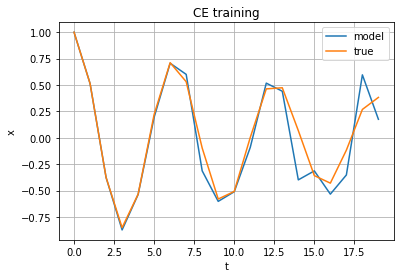

Episode 3400	Average Score: -0.67
273.5811116618196 1.8260587417244354 98.344659577475


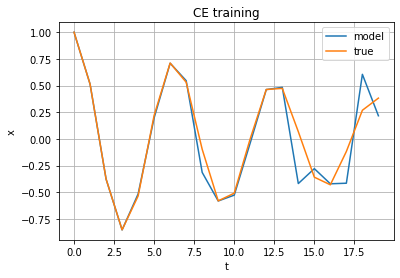

Episode 3600	Average Score: -0.67
302.34633210933066 1.6522449566294843 100


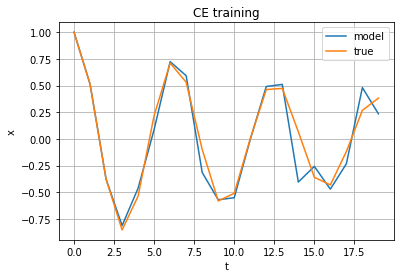

Episode 3800	Average Score: -0.73
334.13602271257656 1.4949756731974462 100


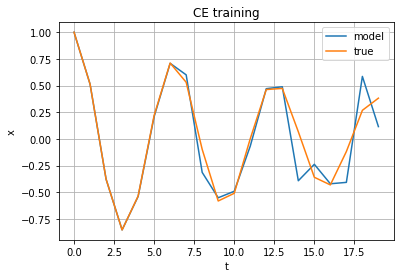

Episode 4000	Average Score: -0.73
369.2681862395043 1.3526760995605478 100


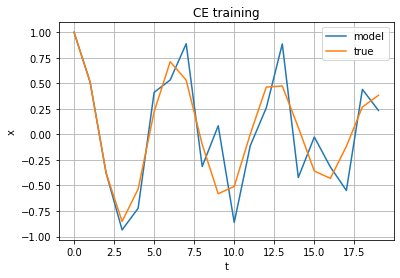

Episode 4200	Average Score: -0.76
408.09426131797017 1.2239213407459084 100


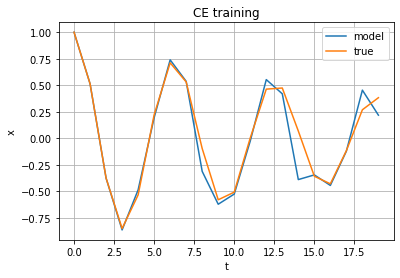

Episode 4400	Average Score: -0.65
451.00263799233073 1.1074221307081 100


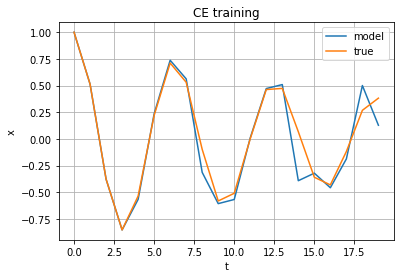

Episode 4600	Average Score: -0.53
498.4225429172544 1.0020119224611754 100


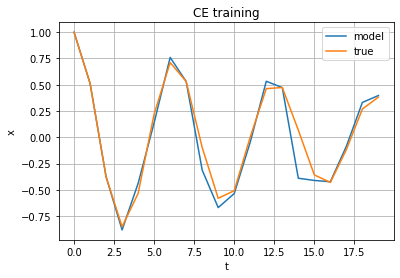

Episode 4800	Average Score: -0.62
550.8283330536232 0.9066352070392095 100


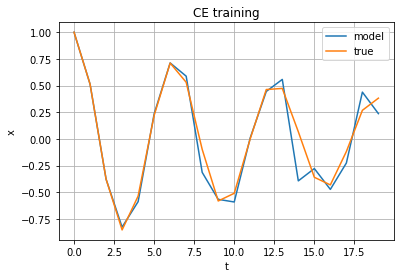

Episode 5000	Average Score: -0.63
608.744240817783 0.8203369443190233 100


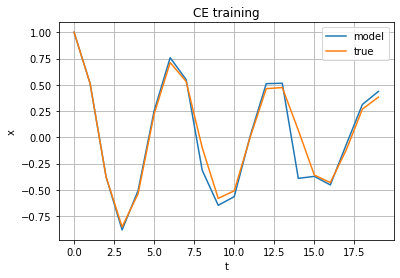

KeyboardInterrupt: 

In [22]:
# TODO: improve CEM with CEM hacks

def cem(n_iterations=10000, max_t=1000, gamma=0.8, print_every=200, pop_size=50, percentile=70, sigma=10, new=True,
        c_pop_size=1.0005, c_sigma=0.9995, c_percentile=1.0001, test_env=test_env, lr=0.5):
    
    scores_deque = deque(maxlen=100)
    scores = []
    
    best_weight = sigma*np.random.randn(agent.get_weights_dim())
    agent.set_weights(best_weight)
    
    print('Episode 0')
    plot_result(test_env, agent)

    for i_iteration in range(1, n_iterations+1):
        
        rnd_impact_amplitude = np.random.uniform(0.5, 1.5)
        rnd_damping_ratio = np.random.uniform(0.03, 0.07)
        
        impact = lambda t: x_impact(t, rnd_impact_amplitude, rnd_damping_ratio)
        history = generate_history(t0, t_step, n_steps, impact=impact)
        env = SimpleModel(history, t0, t_step, n_steps)
        env = ImpactWrapper(env, impact, rnd_impact_amplitude, rnd_damping_ratio)
#         env = NormActionWrapper(env)
    
        
        weights_pop = [best_weight + (sigma*np.random.randn(agent.get_weights_dim())) for i in range(int(pop_size))]
        rewards = np.array([agent.evaluate(env, weights, gamma, max_t) for weights in weights_pop])
        
        thr = np.percentile(rewards, percentile)
        elite_weights = [weights_pop[i] for i, r in enumerate(rewards) if r >= thr-0.01]
        best_weight = (1 - lr) * best_weight + lr * np.array(elite_weights).mean(axis=0)
        

        reward = agent.evaluate(env, best_weight, gamma=1.0)
        scores_deque.append(reward)
        scores.append(reward)
        
        
        pop_size *= c_pop_size
        
        sigma *= c_sigma
        sigma = max(0.0001, sigma)
        
        percentile *= c_percentile
        percentile = min(100, percentile)
        
        torch.save(agent.state_dict(), 'checkpoint.pth')
        
        if i_iteration % print_every == 0:
            print('Episode {}\tAverage Score: {:.2f}'.format(i_iteration, np.mean(scores_deque)))
            print(pop_size, sigma, percentile)
            plot_result(test_env, agent)

        if np.mean(scores_deque)>=-0.1:
            print('\nEnvironment solved in {:d} iterations!\tAverage Score: {:.2f}'.format(i_iteration-100, np.mean(scores_deque)))
            break
    return scores

scores = cem()

# plot the scores
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores)+1), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.title('Score')
plt.show()

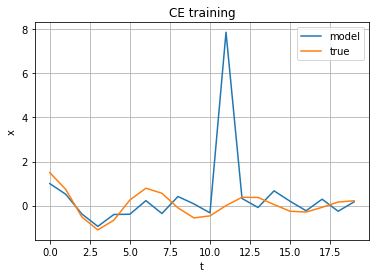

In [24]:
plot_result(test_env, agent)

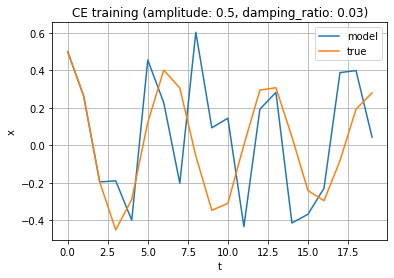

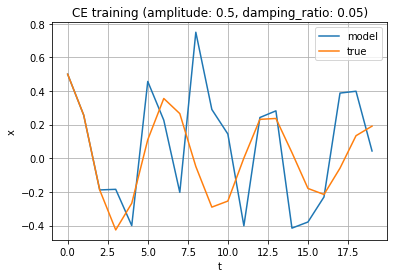

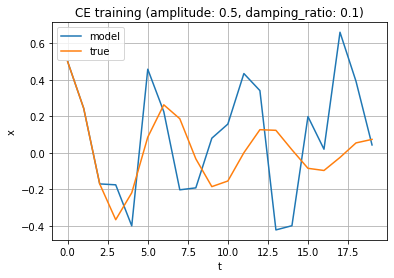

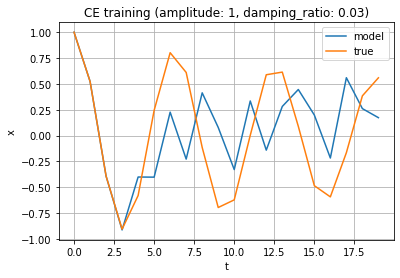

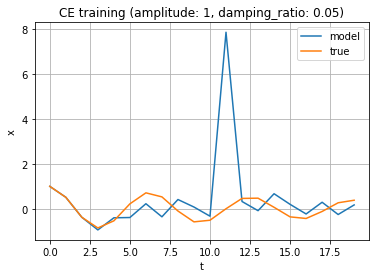

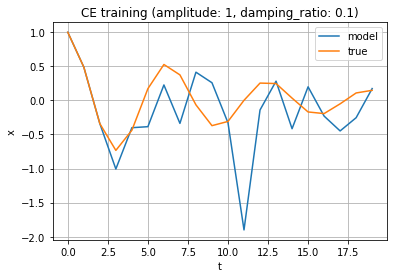

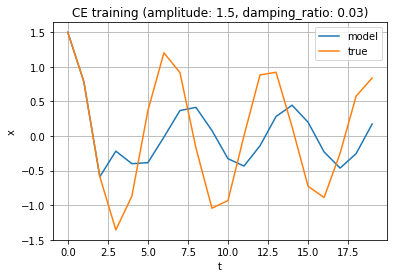

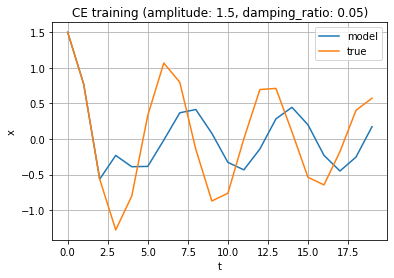

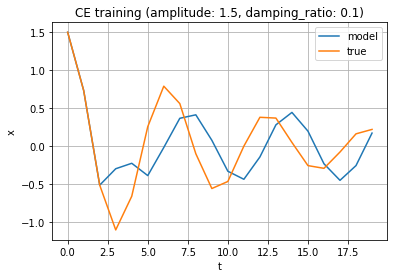

In [23]:
agent.load_state_dict(torch.load('checkpoint.pth'))

impact_amplitude_list = [0.5, 1, 1.5]
damping_ratio_list = [0.03, 0.05, 0.1]

for a in impact_amplitude_list:
    for d in damping_ratio_list:
        impact = lambda t: x_impact(t, a, d)
        history = generate_history(t0, t_step, n_steps, impact=impact)
        env = SimpleModel(history, t0, t_step, n_steps)
        env = ImpactWrapper(env, x_impact, a, d)
        info = f" (amplitude: {a}, damping_ratio: {d})"
        plot_result(env, agent, info)